In [98]:
import typing
import pandas as pd
import dataclasses as dc
from enum import Enum
import numpy as np
import os
print(os.getcwd())

/home/spider/dev/electricity


In [99]:
import dataclasses as dc
from enum import Enum

def crange(start: int, end: int, modulo: int = 24) -> str:
    if start > end:
        while start < modulo:
            yield f"{start:02}:00"
            yield f"{start:02}:30"
            start += 1
        start = 0

    while start < end:
        yield f"{start:02}:00"
        yield f"{start:02}:30"
        start += 1

class Day(Enum):
    MON = 1
    TUE =2
    WED = 3
    THU = 4
    FRI = 5
    SAT = 6
    SUN = 0


@dc.dataclass
class PriceDetail:
    start_time: str
    end_time: str
    price: float
    days: typing.List[int]  = dc.field(default_factory=lambda: [Day.MON, Day.TUE, Day.WED, Day.THU, Day.FRI, Day.SAT, Day.SUN])


@dc.dataclass
class ElectricityPrice:
    name: str
    day: PriceDetail = None
    peak: PriceDetail = None
    night: PriceDetail = None
    ev: PriceDetail = None
    price_per_30min: typing.Dict[Day, typing.Dict[str, float]] = dc.field(default_factory=dict)

    def __post_init__(self) -> None:
        for day in Day:
            self.price_per_30min = {}
            for period_name in ['day', 'peak', 'night', 'ev']: # the order is important
                if period := getattr(self, period_name, None):
                    time_labels = list(
                        crange(
                            int(period.start_time[:2]),
                            int(period.end_time[:2])
                        )
                    )
                    for time_label in time_labels:
                        self.price_per_30min[time_label] = period.price

    def price(self, time_label) -> float:
        return self.price_per_30min[time_label]



In [100]:
prices: typing.List[ElectricityPrice] = [
    ElectricityPrice(
        name = "ElectricIreland: HomeDual+NightBoost + 8.5%% discount",
        day = PriceDetail(
            start_time = '08:00',
            end_time = '23:00',
            price = 0.4230
        ),
        night = PriceDetail(
            start_time = '23:00',
            end_time = '08:00',
            price = 0.2086
        ),
        ev = PriceDetail(
            start_time = '02:00',
            end_time = '04:00',
            price = 0.1225
        ),
    ),
    ElectricityPrice(
        name = "BordGais: Green EV Smart Dual Fuel",
        day = PriceDetail(
            start_time = '08:00',
            end_time = '23:00',
            price = 0.3410
        ),
        night = PriceDetail(
            start_time = '23:00',
            end_time = '08:00',
            price = 0.2571
        ),
        peak = PriceDetail(
            start_time = '17:00',
            end_time = '19:00',
            price = 0.4755
        ),
        ev = PriceDetail(
            start_time = '02:00',
            end_time = '05:00',
            price = 0.0869
        ),
    ),
    ElectricityPrice(
        name = "Airtricity: 35%% discount",
        day = PriceDetail(
            start_time = '08:00',
            end_time = '23:00',
            price = 0.3273
        ),
        night = PriceDetail(
            start_time = '23:00',
            end_time = '08:00',
            price = 0.2481
        ),
        peak = PriceDetail(
            start_time = '17:00',
            end_time = '19:00',
            price = 0.3492
        ),
    ),
]

In [101]:
df = pd.read_csv(os.getcwd() + '/consumption-950495142-14092022-0930.csv')
df = df.drop(columns=['MPRN', 'Meter Serial Number'])
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

In [102]:
df_prices = {}
for price in prices:
    new_df = df.apply(lambda x:  price.price(x.name) * x if x.dtype == np.dtype('float') else x)
    new_df['Total'] = new_df.sum(axis=1, numeric_only=True)
    df_prices[price.name] = new_df

In [103]:
compare_df = pd.DataFrame()
compare_df['Date'] = df['Date']
for name, df_price in df_prices.items():
    compare_df[name.split(':')[0]] = df_price['Total']
compare_df.tail(90).sum(numeric_only=True)

ElectricIreland    352.851956
BordGais           324.377543
Airtricity         362.512587
dtype: float64

<AxesSubplot:xlabel='Date'>

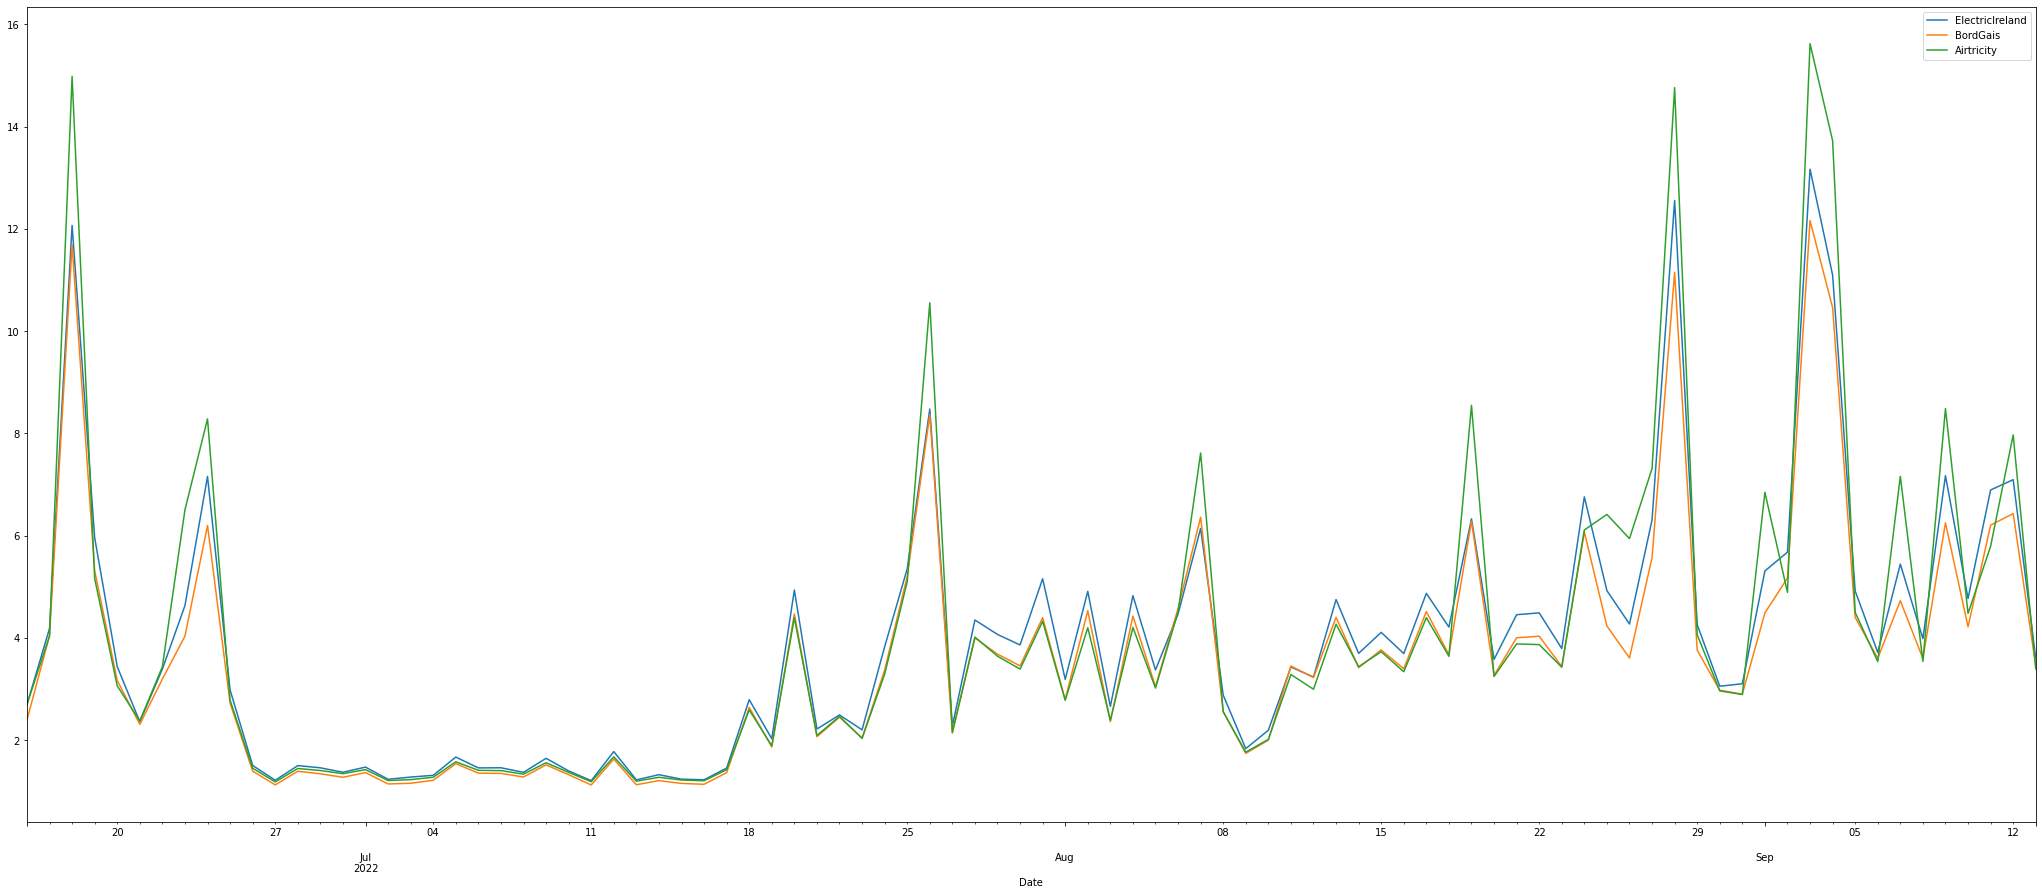

In [104]:
compare_df.tail(90).plot.line(x='Date', rot=0, figsize=(36,15))